# Review: Monte-Carlo Dropout for Uncertainty Estimation in Deep Learning

## 0. Libraries & Setup

In [11]:
# deep learning
import torch
import torch.nn as nn
import torch.nn.functional as F

# data
import numpy as np

# plotting
import matplotlib.pyplot as plt
import seaborn as sns

# other
import tqdm as tqdm

# typing
from typing import Union, Tuple

Setup the device for the training:

In [2]:
# Set device
if ((int(torch.__version__.split(".")[0]) >= 2) or (int(torch.__version__.split(".")[1]) >= 13)) and torch.has_mps:
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

print(device)

mps


Finally, a function that contains some noise:

In [3]:
# Define the function to be modeled
def f(x: Union[torch.Tensor, np.ndarray]) -> Union[torch.Tensor, np.ndarray]:
    return x + np.random.normal(0, 0.1, x.shape[0]) * x ** 2

# Generate input data
X = np.linspace(0, 5, num=1000, endpoint=True)

# Generate target data using the function f(x)
y = f(X)

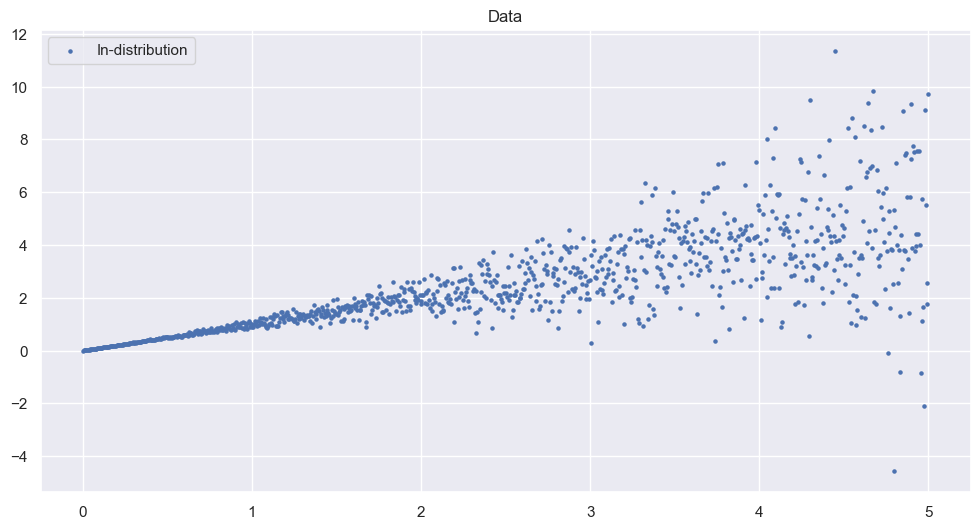

In [4]:
# plot 
sns.set(rc={'figure.figsize':(12, 6)})
plt.scatter(X, y, s=5, label="In-distribution")
plt.legend()
plt.title("Data")
plt.show()

The function is linear with some Gaussian noise added to it that increases with the input value (cone shape).

Let's implement a function that splits data into batches:

In [5]:
# Make batch data 
def make_batch(
    data_size: int, 
    sample_size: int, 
    data_x: torch.Tensor, 
    data_y: torch.Tensor) -> torch.Tensor:
    
    # Make batches(testing)
    batch_idx = np.random.choice(data_size, sample_size)
    
    batch_x = np.zeros([sample_size, 1])
    batch_y = np.zeros([sample_size, 1])
        
    for i in range(batch_idx.shape[0]):
        batch_x[i,:] = data_x[batch_idx[i]]
        batch_y[i,:] = data_y[batch_idx[i]] 
    
    batch_x = torch.FloatTensor(batch_x).to(device)
    batch_y = torch.FloatTensor(batch_y).to(device)
    
    return batch_x, batch_y  

## I. Monte-Carlo Dropout

The first method is to use Monte-Carlo Dropout as explained in the paper: 
[Dropout as a Bayesian Approximation: Representing Model Uncertainty in Deep Learning](https://arxiv.org/pdf/1506.02142v6.pdf).

In this paper, the author shows that a neural network with arbitrary depth and non-linearities, with dropout applied before each weight layer is mathematically equivalent to an approximation to the probabilistic Gaussian process.

Furthermore, this method as opposed to Bayesian Neural Network, is computationally efficient and can be applied to any neural network architecture.

In [6]:
class MC_Dropout_net(nn.Module):
    def __init__(self, p: int = 0.25) -> None:
        super().__init__()
        
        self.fc1 = nn.Linear(1, 32)
        self.fc2 = nn.Linear(32, 32)
        self.fc3 = nn.Linear(32, 1)
        
        self.dropout = nn.Dropout(p=p)
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = F.relu(self.fc1(x))
        
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        
        x = self.fc3(x)
        
        return x

Setup some training parameters:

In [7]:
model = MC_Dropout_net().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001, betas=(0.9, 0.999))
criterion = nn.MSELoss()

Training loop:

In [8]:
for i in tqdm.tqdm(range(1_000)):
    model.train()
    optimizer.zero_grad()
    
    # create a batch
    batch_x, batch_y = make_batch(X.shape[0], 32, X, y)
    
    # forward pass
    preds = model(batch_x)
    
    # calculate loss
    loss = criterion(preds, batch_y)
    
    # backward pass
    loss.backward()
    
    # update parameters
    optimizer.step()
    
    # print loss
    if i % 100 == 0:
        print("Epoch: {0}, Loss: {1}".format(i, loss.item()))

  2%|▏         | 15/1000 [00:00<00:26, 36.67it/s]

Epoch: 0, Loss: 8.125308990478516


 12%|█▎        | 125/1000 [00:01<00:06, 127.83it/s]

Epoch: 100, Loss: 1.0350396633148193


 22%|██▏       | 224/1000 [00:02<00:05, 135.16it/s]

Epoch: 200, Loss: 1.5444376468658447


 32%|███▏      | 323/1000 [00:02<00:04, 138.09it/s]

Epoch: 300, Loss: 1.4482413530349731


 42%|████▏     | 421/1000 [00:03<00:04, 137.81it/s]

Epoch: 400, Loss: 0.36543992161750793


 52%|█████▏    | 522/1000 [00:04<00:03, 138.76it/s]

Epoch: 500, Loss: 0.9786781072616577


 62%|██████▏   | 622/1000 [00:04<00:02, 139.15it/s]

Epoch: 600, Loss: 1.1786013841629028


 72%|███████▏  | 721/1000 [00:05<00:02, 138.36it/s]

Epoch: 700, Loss: 2.839231014251709


 82%|████████▏ | 823/1000 [00:06<00:01, 140.33it/s]

Epoch: 800, Loss: 0.7434959411621094


 93%|█████████▎| 927/1000 [00:07<00:00, 141.24it/s]

Epoch: 900, Loss: 1.7006316184997559


100%|██████████| 1000/1000 [00:07<00:00, 127.47it/s]


Function that estimates the uncertainty:

In [13]:
def uncertainity_estimate(
    x: torch.Tensor, 
    model: MC_Dropout_net, 
    num_samples: int) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    
    outputs = np.hstack([model(x).cpu().detach().numpy() for i in range(num_samples)])
    y_mean = outputs.mean(axis=1)
    y_variance = outputs.var(axis=1)
    y_std = np.sqrt(y_variance)
    
    return outputs, y_mean, y_std

In [14]:
samples = 100
# compute predictions

# Get Unknown dataset and test
x_sample = np.arange(0, 10 + 0.1, 0.1)
X_sample = np.reshape(x_sample, [x_sample.shape[0], 1])

X_sample_tensor = torch.from_numpy(X_sample).float().to(device)

In [16]:
iters_uncertainty = 200

outputs, y_mean, y_std = uncertainity_estimate(X_sample_tensor, model, iters_uncertainty)

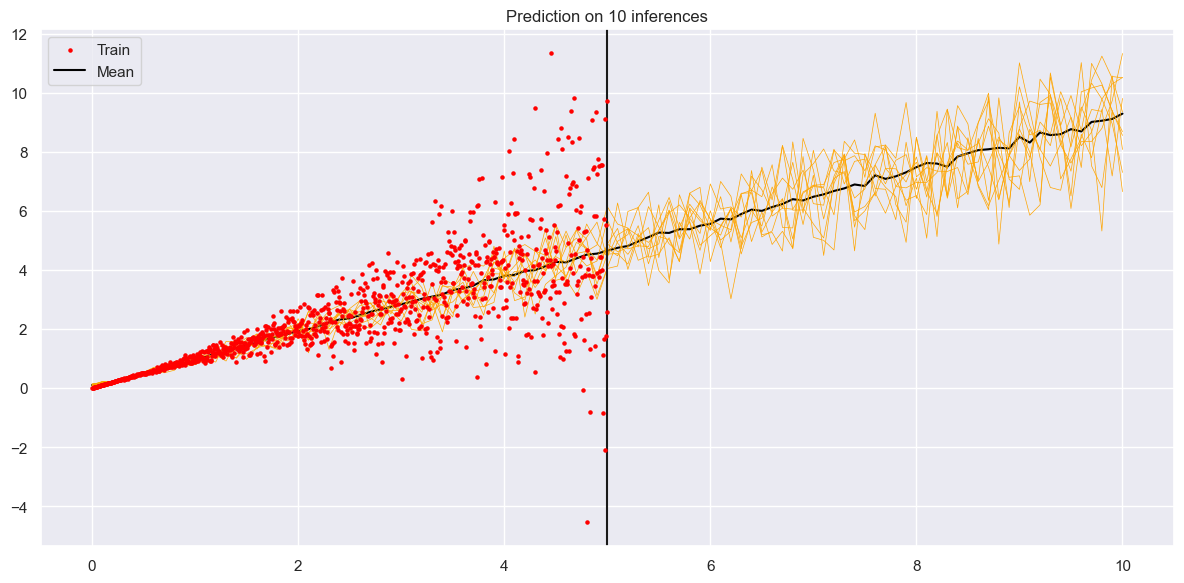

In [17]:
# plot
sns.set(rc={'figure.figsize':(12, 6)})
plt.scatter(X, y, color="red", zorder=10, label="Train", s=5)
# plt.scatter(X_test, y_test, color="blue", zorder=10, label="Test", s=5)
plt.plot(x_sample, y_mean, color="black", label="Mean")

for i in range(10):
    plt.plot(x_sample, outputs[:, i], color="orange", linewidth=0.5)

plt.legend(loc="upper left")
plt.axvline(x=5, color='k')
plt.title('Prediction on 10 inferences')
plt.tight_layout()
plt.show()

## II. Uncertainty Estimation

Now, we can plot the uncertainty of the model:

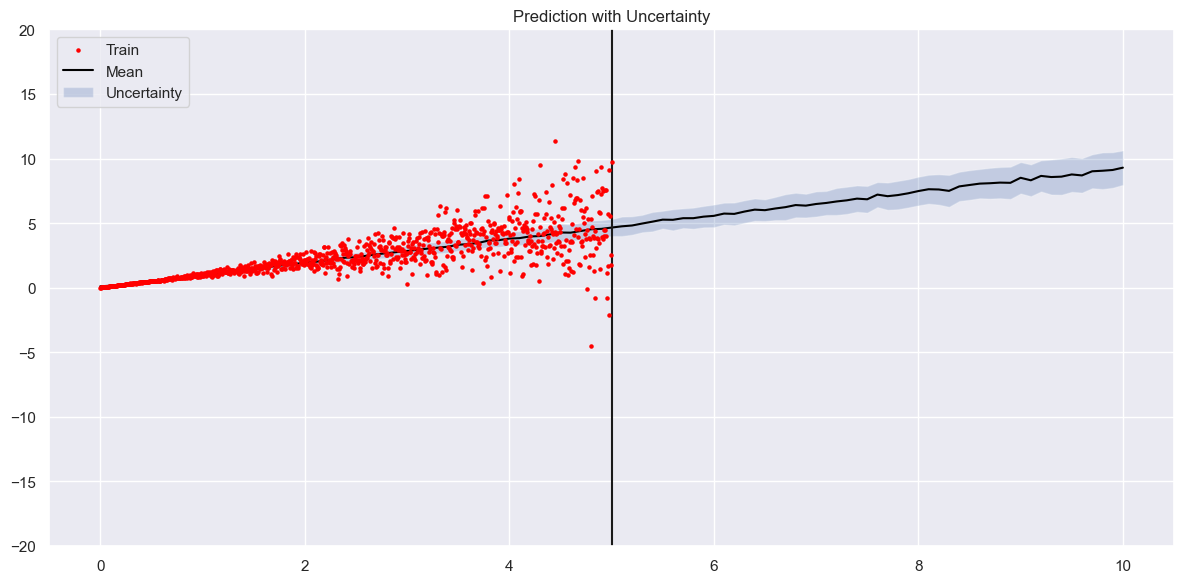

In [18]:
sns.set(rc={'figure.figsize':(12, 6)})
plt.scatter(X, y, color="red", zorder=10, label="Train", s=5)
plt.plot(x_sample, y_mean, color="black", label="Mean")
plt.fill_between(x_sample, y_mean - y_std, y_mean + y_std, alpha=0.25, label="Uncertainty")
plt.ylim([-20, 20])
plt.legend(loc="upper left")
plt.axvline(x=5, color='k')
plt.title('Prediction with Uncertainty')
plt.tight_layout()
plt.show()

The result show that that uncertainty increases with the input value, which is what we expected since the noise increases with the input value.

Furthermore, in regions where the model has not seen any data, the uncertainty increases. However, the rate of increase is quite low compared to what we would expect the noise to be, as shown in the following figure.

In [19]:
# Generate input data
X_ood = np.linspace(5, 10, num=1000, endpoint=True)

# Generate target data using the function f(x)
y_ood = f(X_ood)

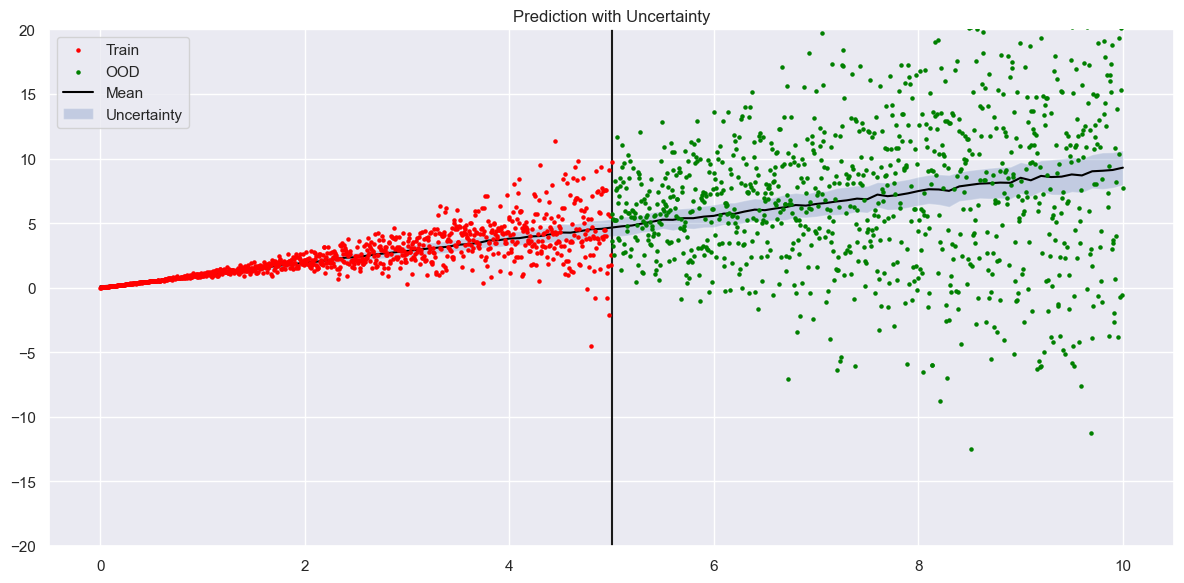

In [20]:
sns.set(rc={'figure.figsize':(12, 6)})
plt.scatter(X, y, color="red", zorder=10, label="Train", s=5)
plt.scatter(X_ood, y_ood, color="green", zorder=10, label="OOD", s=5)
plt.plot(x_sample, y_mean, color="black", label="Mean")
plt.fill_between(x_sample, y_mean - y_std, y_mean + y_std, alpha=0.25, label="Uncertainty")
plt.ylim([-20, 20])
plt.legend(loc="upper left")
plt.axvline(x=5, color='k')
plt.title('Prediction with Uncertainty')
plt.tight_layout()
plt.show()

Thus, it shows that there may be two types of uncertainties, one coming from the model (epistemic) and one coming from the data (aleatoric).

In this case, the aleatoric uncertainty is clearly underestimated/not caught. However, the epistemic uncertainty is well estimated and the chosen model seems correct.

## III. Other studies

Let's remove noise from the data and see what happens:

In [39]:
# Define the function to be modeled
def f(x: Union[torch.Tensor, np.ndarray]) -> Union[torch.Tensor, np.ndarray]:
    return x + 0.01 * x ** 2

# Generate input data
X = np.linspace(0, 5, num=1000, endpoint=True)

# Generate target data using the function f(x)
y = f(X)

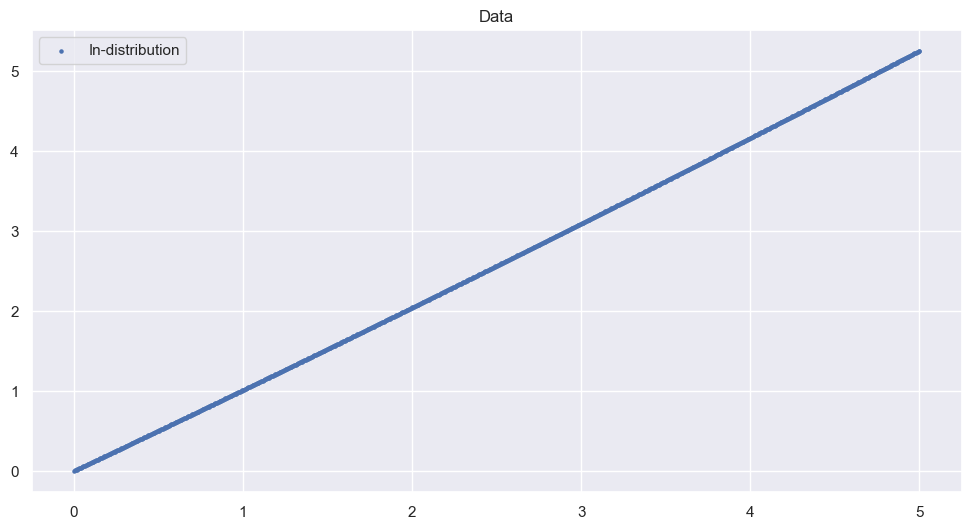

In [40]:
# plot 
sns.set(rc={'figure.figsize':(12, 6)})
plt.scatter(X, y, s=5, label="In-distribution")
plt.legend()
plt.title("Data")
plt.show()

Let's train the model on the data:

In [41]:
model = MC_Dropout_net().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001, betas=(0.9, 0.999))
criterion = nn.MSELoss()

for i in tqdm.tqdm(range(1_000)):
    model.train()
    optimizer.zero_grad()
    
    # create a batch
    batch_x, batch_y = make_batch(X.shape[0], 32, X, y)
    
    # forward pass
    preds = model(batch_x)
    
    # calculate loss
    loss = criterion(preds, batch_y)
    
    # backward pass
    loss.backward()
    
    # update parameters
    optimizer.step()
    
    # print loss
    if i % 100 == 0:
        print("Epoch: {0}, Loss: {1}".format(i, loss.item()))

  2%|▏         | 24/1000 [00:00<00:08, 116.31it/s]

Epoch: 0, Loss: 8.656388282775879


 12%|█▏        | 124/1000 [00:00<00:06, 139.55it/s]

Epoch: 100, Loss: 0.2898810803890228


 23%|██▎       | 227/1000 [00:01<00:05, 142.95it/s]

Epoch: 200, Loss: 0.16598474979400635


 31%|███▏      | 314/1000 [00:02<00:05, 116.90it/s]

Epoch: 300, Loss: 0.21315321326255798


 43%|████▎     | 426/1000 [00:03<00:04, 125.96it/s]

Epoch: 400, Loss: 0.3783019185066223


 53%|█████▎    | 529/1000 [00:04<00:03, 145.29it/s]

Epoch: 500, Loss: 0.24280232191085815


 62%|██████▏   | 619/1000 [00:04<00:02, 144.79it/s]

Epoch: 600, Loss: 0.10533122718334198


 71%|███████▏  | 713/1000 [00:05<00:02, 114.11it/s]

Epoch: 700, Loss: 0.10018029808998108


 82%|████████▏ | 823/1000 [00:06<00:01, 131.07it/s]

Epoch: 800, Loss: 0.07313618063926697


 92%|█████████▎| 925/1000 [00:07<00:00, 142.00it/s]

Epoch: 900, Loss: 0.06251444667577744


100%|██████████| 1000/1000 [00:07<00:00, 131.67it/s]


In [42]:
samples = 100
# compute predictions

# Get Unknown dataset and test
x_sample = np.arange(0, 10 + 0.1, 0.1)
X_sample = np.reshape(x_sample, [x_sample.shape[0], 1])

X_sample_tensor = torch.from_numpy(X_sample).float().to(device)

In [43]:
iters_uncertainty = 200

outputs, y_mean, y_std = uncertainity_estimate(X_sample_tensor, model, iters_uncertainty)

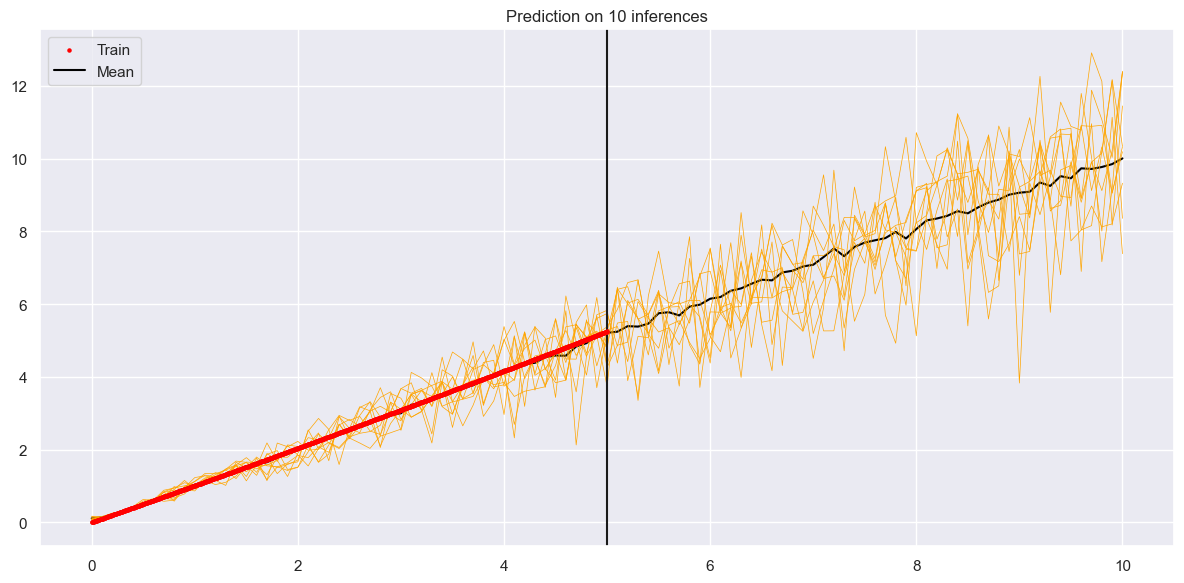

In [44]:
# plot
sns.set(rc={'figure.figsize':(12, 6)})
plt.scatter(X, y, color="red", zorder=10, label="Train", s=5)
# plt.scatter(X_test, y_test, color="blue", zorder=10, label="Test", s=5)
plt.plot(x_sample, y_mean, color="black", label="Mean")

for i in range(10):
    plt.plot(x_sample, outputs[:, i], color="orange", linewidth=0.5)

plt.legend(loc="upper left")
plt.axvline(x=5, color='k')
plt.title('Prediction on 10 inferences')
plt.tight_layout()
plt.show()

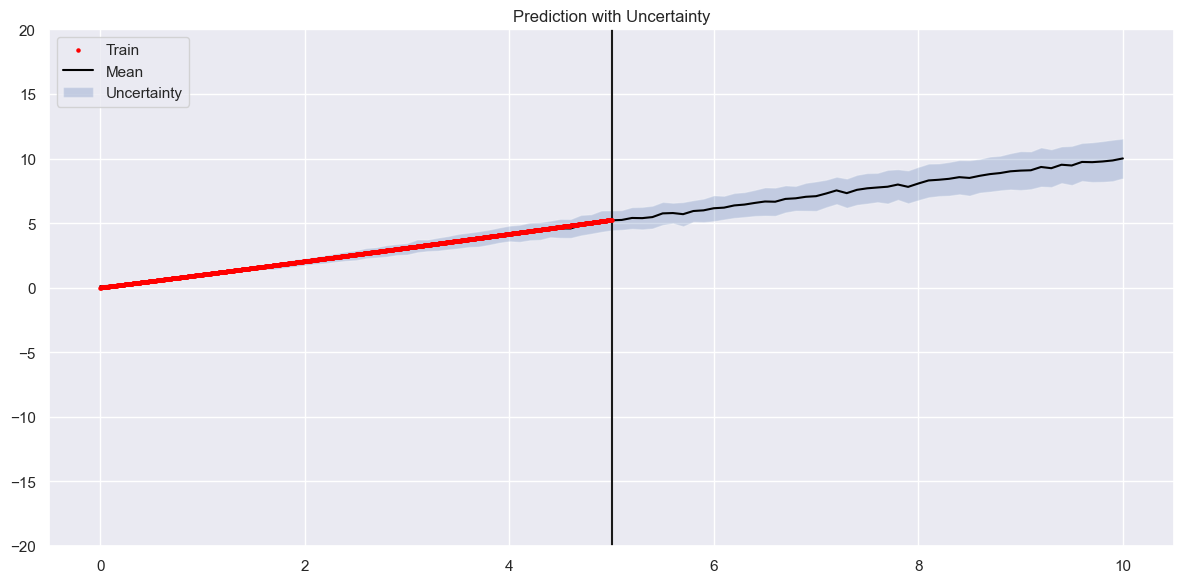

In [45]:
sns.set(rc={'figure.figsize':(12, 6)})
plt.scatter(X, y, color="red", zorder=10, label="Train", s=5)
plt.plot(x_sample, y_mean, color="black", label="Mean")
plt.fill_between(x_sample, y_mean - y_std, y_mean + y_std, alpha=0.25, label="Uncertainty")
plt.ylim([-20, 20])
plt.legend(loc="upper left")
plt.axvline(x=5, color='k')
plt.title('Prediction with Uncertainty')
plt.tight_layout()
plt.show()

This time, the data does not have any noise, thus the uncertainty comes only from the model.

In regions where the model has not seen any data, the uncertainty keeps increasing has the model has no knowledge on what happens in this region and fails to generalize.

This is shown in the following figure:

In [46]:
# Generate input data
X_ood = np.linspace(5, 10, num=1000, endpoint=True)

# Generate target data using the function f(x)
y_ood = f(X_ood)

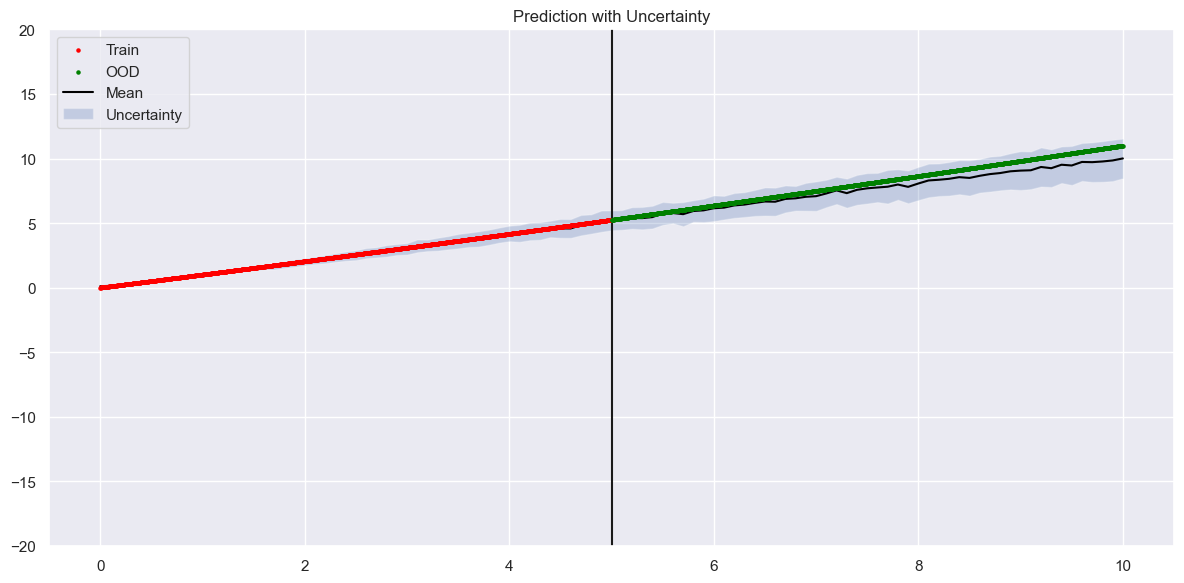

In [47]:
sns.set(rc={'figure.figsize':(12, 6)})
plt.scatter(X, y, color="red", zorder=10, label="Train", s=5)
plt.scatter(X_ood, y_ood, color="green", zorder=10, label="OOD", s=5)
plt.plot(x_sample, y_mean, color="black", label="Mean")
plt.fill_between(x_sample, y_mean - y_std, y_mean + y_std, alpha=0.25, label="Uncertainty")
plt.ylim([-20, 20])
plt.legend(loc="upper left")
plt.axvline(x=5, color='k')
plt.title('Prediction with Uncertainty')
plt.tight_layout()
plt.show()